This dataset is a collection of attributes of startup companies linked to their dependent variable of success. It can be found at https://www.kaggle.com/datasets/manishkc06/startup-success-prediction, with data provided by Ramkishan Panthena.

In [20]:
import pandas as pd
import numpy as np

In [21]:
df = pd.read_csv('startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


There are many attributes in this dataset that are redundant or unnecessary. For example, location information can be reduced to a single attribute of state_code. Including the city name may be too granular for this analysis, as is including coordinates and zip code. First, however, the number of NaN counts per attribute will be assessed to help determine which attributes are worth selecting over others. 

In [22]:
nas = df.isna().sum()
nas[nas > 0]

Unnamed: 6                  493
closed_at                   588
age_first_milestone_year    152
age_last_milestone_year     152
state_code.1                  1
dtype: int64

Fortunately, all of the attributes containing null values can be safely dropped. Going though the attributes to drop:

Beyond state_code, all other location attributes will be dropped. These are either superfluous or likely too granular for the purpose of this EDA.

The category of the business is already captured in category_code, and thus the remaining category Booleans can be dropped. 

Information pertaining to last funding dates can be dropped, as well as closed dates, as they are causatively effected by whether the company closed or not. 

Information pertaining to company name or ID can be dropped.

In [23]:
loc_to_drop = ['latitude', 'longitude', 'zip_code', 'city', 'state_code.1', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 
               'is_otherstate']
cat_to_drop = ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
              'is_biotech', 'is_consulting', 'is_othercategory']
extras_to_drop = ['Unnamed: 0', 'id', 'Unnamed: 6', 'name', 'labels', 'closed_at', 'last_funding_at', 'age_last_funding_year', 
                  'age_first_milestone_year', 'age_last_milestone_year', 'object_id']

In [24]:
df = pd.read_csv('startup_data.csv')
df.drop(loc_to_drop, axis=1, inplace=True)
df.drop(cat_to_drop, axis=1, inplace=True)
df.drop(extras_to_drop, axis=1, inplace=True)

Specific dates of founding and first funding are not especially useful, as they are much too granular. These will be converted to years to get a better sense of any years that may have been optimal for either of these actions.

Additionally, the status column will be converted from string to an integer Boolean, with 1 denoting that the company was acquired.

In [25]:
df['founded_at'] = df['founded_at'].str.slice(start=-4, stop=None)
df['first_funding_at'] = df['first_funding_at'].str.slice(start=-4, stop=None)

df['status'] = df['status'].map({'acquired': 1, 'closed': 0})
df.head()

,state_code,founded_at,first_funding_at,age_first_funding_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,2007,2009,2.2493,3,3,375000,3,music,0,1,0,0,0,0,1.0000,0,1
1,CA,2000,2005,5.1260,9,4,40100000,1,enterprise,1,0,0,1,1,1,4.7500,1,1
2,CA,2009,2010,1.0329,5,1,2600000,2,web,0,0,1,0,0,0,4.0000,1,1
3,CA,2002,2005,3.1315,5,3,40000000,1,software,0,0,0,1,1,1,3.3333,1,1
4,CA,2010,2010,0.0000,2,2,1300000,1,games_video,1,1,0,0,0,0,1.0000,1,0


The dataset is now much cleaner for the purpose of EDA. 

Next, a function is created to obtain success rates based on various individual categories and plot their success rates. The function allows for sorting of the returned series, as well as exclusion of data points that lack enough entries to meet a defined threshold. 

In [104]:
def attr_viz(attr, sort=False, threshold=0):
    df_attr = df[[attr, 'status']]

    attr_acq = df_attr.groupby([attr]).sum()


    attr_tot = df_attr.groupby([attr]).count()
    attr_clo = attr_tot - attr_acq


    attr_all = pd.concat([attr_acq, attr_clo], axis=1)
    attr_all.columns.values[0] = 'acquired'
    attr_all.columns.values[1] = 'closed'
    attr_all = attr_all[attr_all['acquired'] + attr_all['closed'] > threshold]
    
    attr_all.plot.bar()
    
    acq_rates = np.round(attr_acq/attr_tot, 2)
    acq_rates = pd.concat([acq_rates, attr_tot], axis=1)
    acq_rates.columns.values[0] = '% acquired'
    acq_rates.columns.values[1] = 'total'
    acq_rates = acq_rates[acq_rates['total'] > threshold]
    
    if sort:
        return acq_rates.sort_values('% acquired', ascending=False)
    
    return acq_rates

,% acquired,total
state_code,,
CA,0.68,488
CO,0.74,19
GA,0.55,11
IL,0.50,18
MA,0.77,83
NY,0.73,106
PA,0.35,17
TX,0.55,42
VA,0.54,13


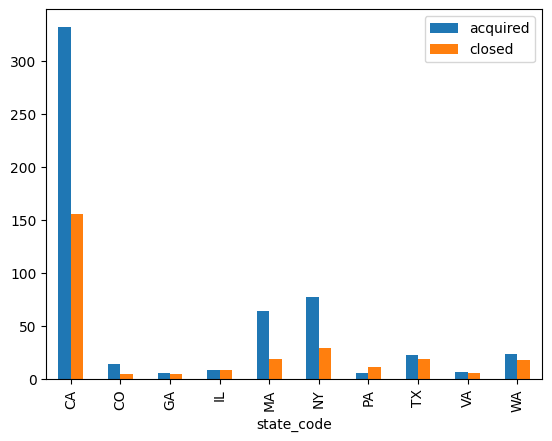

In [106]:
attr_viz('state_code', threshold=10)

,% acquired,total
category_code,,
analytics,0.84,19
security,0.79,19
enterprise,0.77,73
advertising,0.73,62
network_hosting,0.71,34
semiconductor,0.69,35
software,0.66,153
mobile,0.66,79
biotech,0.65,34


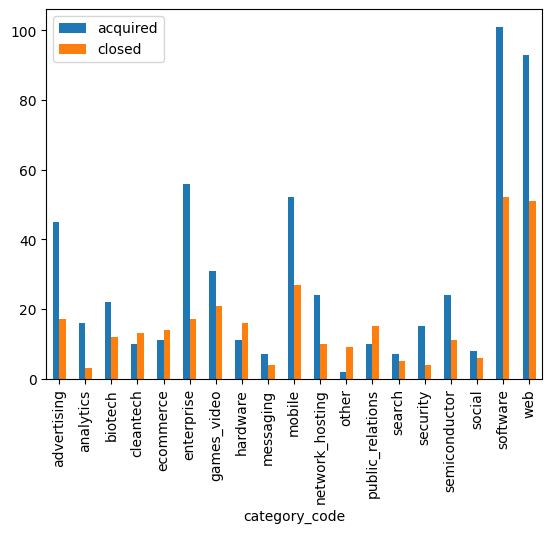

In [107]:
attr_viz('category_code', sort=True, threshold=10)